### 311 Road Condition Data in Oakland - 2019

**Note: I had a LOT of trouble with this lab, but tried to document it all. I learned a lot and produced a folium map of the first objective at the bottom. Will probably create a fresh notebook after seeking guidance this week.** 

This notebook will attempt to cover two items related to our group project:
- Map the plots of 311 complaints about potholes or road deteriation. 
- Categorize the plots by length of time for request resolution. 

These maps will then be compared to the existing maps we created that plotted out racial and income census information for Oakland to see if there are any visually evident connections about road conditions or 311 response time to either of those factors. My partner is conducting this same visualization for 2009, so we also take a look to see how these data points have changed over time. We hope these analysis will help guide our future maps under this project. 

**Import Libraries**

In [ ]:
# for data wrangling
import pandas as pd

# to read and visualize spatial data
import geopandas as gpd

# for basemaps 
import contextily as ctx

# to for advanced plotting
import matplotlib.pyplot as plt

***Add Data***

In [4]:
gdf = gpd.read_file('Data/2019_OAK_311.csv')

**Data Exploration**

In [5]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5294 entries, 0 to 5293
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   REQUESTID        5294 non-null   object  
 1   DATETIMEINIT     5294 non-null   object  
 2   SOURCE           5294 non-null   object  
 3   DESCRIPTION      5294 non-null   object  
 4   REQCATEGORY      5294 non-null   object  
 5   REQADDRESS       5294 non-null   object  
 6   STATUS           5294 non-null   object  
 7   REFERREDTO       5294 non-null   object  
 8   DATETIMECLOSED   5294 non-null   object  
 9   SRX              5294 non-null   object  
 10  SRY              5294 non-null   object  
 11  COUNCILDISTRICT  5294 non-null   object  
 12  BEAT             5294 non-null   object  
 13  Time to Close    5294 non-null   object  
 14  geometry         0 non-null      geometry
dtypes: geometry(1), object(14)
memory usage: 620.5+ KB


Looks like the geometry column is empty, let's make sure there is geo data to work with. 

In [6]:
gdf.head()

REQUESTID   DATETIMEINIT       SOURCE                     DESCRIPTION  \
0    927576  7/23/19 15:38  SeeClickFix   Streets - Potholes/Depression   
1    918469  6/25/19 08:34  SeeClickFix      Streets - Guardrail Repair   
2    922854   7/9/19 12:17  SeeClickFix   Streets - Potholes/Depression   
3    917741  6/22/19 16:00  SeeClickFix  Streets - Street Deterioration   
4    927190  7/22/19 16:17  SeeClickFix  Streets - Street Deterioration   

  REQCATEGORY                                REQADDRESS  STATUS REFERREDTO  \
0    STREETSW  (37.83815973132404, -122.25130291211626)  CLOSED              
1    STREETSW    (37.85030835735331, -122.225949000362)  CLOSED              
2    STREETSW  (37.79428033082835, -122.25218046709783)  CLOSED              
3    STREETSW   (37.80751843733346, -122.1784516749125)    OPEN              
4    STREETSW  (37.82810651117344, -122.19566579203311)    OPEN              

  DATETIMECLOSED          SRX          SRY COUNCILDISTRICT BEAT Time to Close  \
0  7/26/19 13:45  6055962.501   2132386.75            CCD1  12Y             3   
1  7/10/19 18:11  6063364.409  2136673.615            CCD1  13Y            15   
2  7/22/19 16:40  6055410.001  2116416.751            CCD2  19X            13   
3                 6076796.539  2120845.822            CCD4  22Y          Open   
4                   6071960.1   2128430.85            CCD4  13Z          Open   

  geometry  
0     None  
1     None  
2     None  
3     None  
4     None

Great, there are coordinates in the REQADDRESS column. There is also a few columns I want to explore here: Source, Description and Time to Close. 

In [7]:
gdf['SOURCE'].value_counts()

SeeClickFix       3593
Phone             1022
Email              307
Phone or Email     271
Voicemail           91
Other               10
Name: SOURCE, dtype: int64

Ok, so the majority (3593/5294=67.8%) of the 311 complaints in 2019 were made on the [SeeClickFix](https://seeclickfix.com/oakland) app or website.

In [10]:
gdf['DESCRIPTION'].value_counts()

Streets - Potholes/Depression                        4207
Streets - Street Deterioration                        653
Streets/Sidewalks - Curb & Gutter Repair              181
Streets - Mudslides/Landslides                         52
Streets/Sidewalks - Pooling Water                      47
Streets/Sidewalks - Other/Complex                      28
Sidewalk - Damage                                      24
Streets - Guardrail Repair                             22
Streets/Sidewalks - Cross-Culvert Repair               15
Streets - Berm Repair or Install                       15
Streets - Speed Bump Repair                            11
Streets - Mill & Fill                                   9
Streets/Sidewalks - Pathway Repair                      8
Fence - Repair or Install Along Street                  7
Inspections - Utility-Related Infrastructure            2
Pothole (report from SeeClickFix)                       2
Sewers - Other/Complex                                  1
Traffic - Sign

Ok wow, a lot of different requests are included in the street repair category (STREETSW) of the 311 dataset. While they may be different then a strict potholes inquiry into the data, the other types of requests are related to overall road condition. Additionally, "Potholes/Depression" and "Steet Deterioration" make up 92% of requests, so the other requests types shouldn't really skew the results. 

Given the above, along with the lack of access to operator procedures on assigning descriptions, our group made the determination to include these other requests in our analysis. 

In [12]:
gdf['COUNCILDISTRICT'].value_counts()

CCD4    1043
CCD1     788
CCD2     758
CCD7     708
CCD5     692
CCD3     668
CCD6     466
         171
Name: COUNCILDISTRICT, dtype: int64

This gives us an early peak into the geographic distorubtion of requests. Assuming these districts are roughly equal in population, there does appear to be an abnormal distrobution of requests geographically. 

In [15]:
gdf['Time to Close'].head()

0       3
1      15
2      13
3    Open
4    Open
Name: Time to Close, dtype: object

So not all requests from 2019 are open. I want to know some stats on those that were closed, but I need to filter out the "Open" string value to conduct that analysis. 

In [20]:
gdf[gdf['Time to Close']!='Open']

REQUESTID   DATETIMEINIT       SOURCE                    DESCRIPTION  \
0       927576  7/23/19 15:38  SeeClickFix  Streets - Potholes/Depression   
1       918469  6/25/19 08:34  SeeClickFix     Streets - Guardrail Repair   
2       922854   7/9/19 12:17  SeeClickFix  Streets - Potholes/Depression   
5       926601  7/20/19 15:18  SeeClickFix  Streets - Potholes/Depression   
6       924666  7/15/19 10:07  SeeClickFix  Streets - Potholes/Depression   
...        ...            ...          ...                            ...   
5287    920784   7/2/19 09:50  SeeClickFix  Streets - Potholes/Depression   
5288    928026  7/24/19 19:20  SeeClickFix  Streets - Potholes/Depression   
5291    916830  6/19/19 12:43  SeeClickFix  Streets - Potholes/Depression   
5292    916568  6/18/19 19:20  SeeClickFix  Streets - Potholes/Depression   
5293    928990  7/28/19 19:02  SeeClickFix  Streets - Potholes/Depression   

     REQCATEGORY                                 REQADDRESS  STATUS  \
0       STREETSW   (37.83815973132404, -122.25130291211626)  CLOSED   
1       STREETSW     (37.85030835735331, -122.225949000362)  CLOSED   
2       STREETSW   (37.79428033082835, -122.25218046709783)  CLOSED   
5       STREETSW  (37.839213002114015, -122.26909949952085)  CLOSED   
6       STREETSW   (37.78459760436604, -122.20013066159879)  CLOSED   
...          ...                                        ...     ...   
5287    STREETSW   (37.80935386325996, -122.25365440068408)  CLOSED   
5288    STREETSW   (37.79529503933292, -122.24329680782341)  CLOSED   
5291    STREETSW  (37.800865586377256, -122.24292681189839)  CLOSED   
5292    STREETSW  (37.843036469086414, -122.22189311623565)  CLOSED   
5293    STREETSW  (37.835869380751305, -122.25516199927547)  CLOSED   

     REFERREDTO DATETIMECLOSED          SRX          SRY COUNCILDISTRICT BEAT  \
0                7/26/19 13:45  6055962.501   2132386.75            CCD1  12Y   
1                7/10/19 18:11  6063364.409  2136673.615            CCD1  13Y   
2                7/22/19 16:40  6055410.001  2116416.751            CCD2  19X   
5                7/25/19 09:17  6050831.438   2132866.86            CCD1  11X   
6                7/18/19 17:40      6070383  2112614.251            CCD4  24Y   
...         ...            ...          ...          ...             ...  ...   
5287             9/13/19 17:21  6055087.031  2121912.384            CCD3  14X   
5288             8/13/19 12:52  6057983.337   2116738.23            CCD2  17X   
5291              7/1/19 06:25      6058128   2118764.25            CCD2  17Y   
5292             6/24/19 14:52  6064486.543  2134004.608            CCD1  13Y   
5293             7/30/19 06:15  6054832.646  2131573.798            CCD1  12Y   

     Time to Close geometry  
0                3     None  
1               15     None  
2               13     None  
5                5     None  
6                3     None  
...            ...      ...  
5287            73     None  
5288            20     None  
5291            12     None  
5292             6     None  
5293             2     None  

[3787 rows x 15 columns]

There we go. Looks like about 2/3rds of the requests were closed. 

In [21]:
gdf_no_open = gdf[gdf['Time to Close']!='Open']

In [30]:
gdf_no_open['Time to Close'].describe()

count     3787
unique     593
top          2
freq       155
Name: Time to Close, dtype: object

Well that's not what I was expecting... let's see what's going on. 

In [38]:
gdf_no_open.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3787 entries, 0 to 5293
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   REQUESTID        3787 non-null   object  
 1   DATETIMEINIT     3787 non-null   object  
 2   SOURCE           3787 non-null   object  
 3   DESCRIPTION      3787 non-null   object  
 4   REQCATEGORY      3787 non-null   object  
 5   REQADDRESS       3787 non-null   object  
 6   STATUS           3787 non-null   object  
 7   REFERREDTO       3787 non-null   object  
 8   DATETIMECLOSED   3787 non-null   object  
 9   SRX              3787 non-null   object  
 10  SRY              3787 non-null   object  
 11  COUNCILDISTRICT  3787 non-null   object  
 12  BEAT             3787 non-null   object  
 13  Time to Close    3787 non-null   object  
 14  geometry         0 non-null      geometry
dtypes: geometry(1), object(14)
memory usage: 473.4+ KB


Ahh, so even though I filtered out the string value, the time to close column values are not integers so I can't see statistics. Let's change that:

In [44]:
gdf_no_open['Time to Close'] = gdf_no_open['Time to Close'].astype('int64')

In [45]:
gdf_no_open.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3787 entries, 0 to 5293
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   REQUESTID        3787 non-null   object  
 1   DATETIMEINIT     3787 non-null   object  
 2   SOURCE           3787 non-null   object  
 3   DESCRIPTION      3787 non-null   object  
 4   REQCATEGORY      3787 non-null   object  
 5   REQADDRESS       3787 non-null   object  
 6   STATUS           3787 non-null   object  
 7   REFERREDTO       3787 non-null   object  
 8   DATETIMECLOSED   3787 non-null   object  
 9   SRX              3787 non-null   object  
 10  SRY              3787 non-null   object  
 11  COUNCILDISTRICT  3787 non-null   object  
 12  BEAT             3787 non-null   object  
 13  Time to Close    3787 non-null   int64   
 14  geometry         0 non-null      geometry
dtypes: geometry(1), int64(1), object(13)
memory usage: 473.4+ KB


And now that we have interger values...

In [46]:
gdf_no_open['Time to Close'].describe()

count    3787.000000
mean      140.855294
std       225.482150
min         0.000000
25%         7.000000
50%        32.000000
75%       127.000000
max       995.000000
Name: Time to Close, dtype: float64

In [47]:
gdf_no_open['Time to Close'].mean()

140.85529442830736

In [48]:
gdf_no_open['Time to Close'].median()

32.0

Couple things we learn from this. 
- The large difference between the mean and median indicate that there are a few requests that took a long time to close and are skewing the mean. This is backed up by the fact that the mean is higher than the 75th percentile, 
- The max value of 995 is nearly 3 years for a request! This means that requests from 2019 are still being addressed now. 
- The median lines up pretty nicely with days in a month, so we can say that half of requests are addressed in roughly a month. 

<AxesSubplot:ylabel='Frequency'>

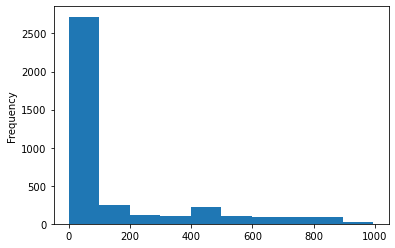

In [52]:
gdf_no_open['Time to Close'].plot.hist(bins=10)

Yeah, not a normal distrobution at all.

***Creating bins***

So I know I want to incoporate the time to close data into my geospatial analysis. The values have a really wide range so in order to make this work visually, I'm going to need to create some bins to group the distrobution. 

In [53]:
pd.qcut(gdf_no_open['Time to Close'], q=5)

0       (-0.001, 6.0]
1         (6.0, 19.0]
2         (6.0, 19.0]
5       (-0.001, 6.0]
6       (-0.001, 6.0]
            ...      
5287    (55.0, 236.4]
5288     (19.0, 55.0]
5291      (6.0, 19.0]
5292    (-0.001, 6.0]
5293    (-0.001, 6.0]
Name: Time to Close, Length: 3787, dtype: category
Categories (5, interval[float64, right]): [(-0.001, 6.0] < (6.0, 19.0] < (19.0, 55.0] < (55.0, 236.4] < (236.4, 995.0]]

I created quintiles for my distrobution. Now I need to rename it for future analysis and mapping.

In [62]:
gdf['quintile_close'] = pd.qcut(gdf_no_open['Time to Close'], q=5)

In [63]:
gdf.head()

REQUESTID   DATETIMEINIT       SOURCE                     DESCRIPTION  \
0    927576  7/23/19 15:38  SeeClickFix   Streets - Potholes/Depression   
1    918469  6/25/19 08:34  SeeClickFix      Streets - Guardrail Repair   
2    922854   7/9/19 12:17  SeeClickFix   Streets - Potholes/Depression   
3    917741  6/22/19 16:00  SeeClickFix  Streets - Street Deterioration   
4    927190  7/22/19 16:17  SeeClickFix  Streets - Street Deterioration   

  REQCATEGORY                                REQADDRESS  STATUS REFERREDTO  \
0    STREETSW  (37.83815973132404, -122.25130291211626)  CLOSED              
1    STREETSW    (37.85030835735331, -122.225949000362)  CLOSED              
2    STREETSW  (37.79428033082835, -122.25218046709783)  CLOSED              
3    STREETSW   (37.80751843733346, -122.1784516749125)    OPEN              
4    STREETSW  (37.82810651117344, -122.19566579203311)    OPEN              

  DATETIMECLOSED          SRX          SRY COUNCILDISTRICT BEAT Time to Close  \
0  7/26/19 13:45  6055962.501   2132386.75            CCD1  12Y             3   
1  7/10/19 18:11  6063364.409  2136673.615            CCD1  13Y            15   
2  7/22/19 16:40  6055410.001  2116416.751            CCD2  19X            13   
3                 6076796.539  2120845.822            CCD4  22Y          Open   
4                   6071960.1   2128430.85            CCD4  13Z          Open   

  geometry quantile_close quintile_close  
0     None  (-0.001, 6.0]  (-0.001, 6.0]  
1     None    (6.0, 19.0]    (6.0, 19.0]  
2     None    (6.0, 19.0]    (6.0, 19.0]  
3     None            NaN            NaN  
4     None            NaN            NaN

Now we have a new column for quintiles based on on time to closure. 

*Note: I placed this quintile column back in our original unfiltered dataset, so that "Open" complaints are functionally a 6th bin with "NaN" value. We still want to include these requests in our map*

***Plotting***

Let's start with just plotting all the requests for 2019.

<AxesSubplot:>

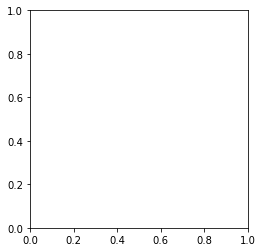

In [ ]:
gdf.plot()

Awesome, we got nothing. I think that's because of that blank geometry column. 

In [68]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5294 entries, 0 to 5293
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   REQUESTID        5294 non-null   object  
 1   DATETIMEINIT     5294 non-null   object  
 2   SOURCE           5294 non-null   object  
 3   DESCRIPTION      5294 non-null   object  
 4   REQCATEGORY      5294 non-null   object  
 5   REQADDRESS       5294 non-null   object  
 6   STATUS           5294 non-null   object  
 7   REFERREDTO       5294 non-null   object  
 8   DATETIMECLOSED   5294 non-null   object  
 9   SRX              5294 non-null   object  
 10  SRY              5294 non-null   object  
 11  COUNCILDISTRICT  5294 non-null   object  
 12  BEAT             5294 non-null   object  
 13  Time to Close    5294 non-null   object  
 14  geometry         0 non-null      geometry
 15  quantile_close   3787 non-null   category
 16  quintile_close   3787 non-null   c

Yeah, I need to drop the geometry column and set "REQADDRESS" to be the geometry column for pandas to pull coordinates from.

In [77]:
gdf['REQADDRESS'] = gdf['REQADDRESS'].astype('geometry')

TypeError: Input must be valid geometry objects: (37.83815973132404, -122.25130291211626)

In [78]:
gdf['REQADDRESS'].sample(10)

4081    (37.786665045412136, -122.23588680760282)
212     (37.778835039978084, -122.20110681950966)
3283    (37.823530791660865, -122.18810859214716)
3843     (37.75327504215296, -122.18501682213366)
1421     (37.82526192400078, -122.27454400222739)
4409    (37.745941657469984, -122.17925464354983)
4674     (37.81372475202987, -122.24993705807226)
3452     (37.80372615363815, -122.27821409832063)
2590    (37.758539446138805, -122.18953045928544)
2912    (37.800918962202125, -122.21815644846016)
Name: REQADDRESS, dtype: object

Weird, these look like coordinates.

In [92]:
gdf_sorted = gdf.sort_values(by='REQADDRESS',ascending = True)

In [93]:
gdf_sorted.head(20)

REQUESTID    DATETIMEINIT          SOURCE  \
1284    866049   1/14/19 08:04  Phone or Email   
2811    885105   3/11/19 10:18           Phone   
516     936712   8/20/19 14:33  Phone or Email   
1860    866046   1/14/19 08:01  Phone or Email   
1024    885151   3/11/19 11:26           Phone   
4799    932698    8/8/19 09:57           Phone   
3159    886519   3/15/19 14:59           Phone   
1751    866039   1/14/19 07:41  Phone or Email   
2043    885136   3/11/19 11:01           Phone   
740     971427  12/20/19 13:30     SeeClickFix   
636     971183  12/19/19 16:10  Phone or Email   
226     937313   8/22/19 08:58     SeeClickFix   
4288    897792   4/22/19 14:22     SeeClickFix   
82      944305   9/13/19 20:29     SeeClickFix   
4748    925138   7/16/19 11:02     SeeClickFix   
1705    865409   1/10/19 13:59           Phone   
5223    925139   7/16/19 11:07     SeeClickFix   
4843    916746   6/19/19 10:13           Phone   
3943    907392   5/23/19 12:48     SeeClickFix   
4984    925152   7/16/19 11:18     SeeClickFix   

                                 DESCRIPTION REQCATEGORY  \
1284           Streets - Potholes/Depression    STREETSW   
2811           Streets - Potholes/Depression    STREETSW   
516            Streets - Potholes/Depression    STREETSW   
1860  Fence - Repair or Install Along Street    STREETSW   
1024           Streets - Potholes/Depression    STREETSW   
4799           Streets - Potholes/Depression    STREETSW   
3159           Streets - Potholes/Depression    STREETSW   
1751          Streets - Mudslides/Landslides    STREETSW   
2043           Streets - Potholes/Depression    STREETSW   
740            Streets - Potholes/Depression    STREETSW   
636            Streets - Potholes/Depression    STREETSW   
226            Streets - Potholes/Depression    STREETSW   
4288           Streets - Potholes/Depression    STREETSW   
82             Streets - Potholes/Depression    STREETSW   
4748           Streets - Potholes/Depression    STREETSW   
1705           Streets - Potholes/Depression    STREETSW   
5223           Streets - Potholes/Depression    STREETSW   
4843           Streets - Potholes/Depression    STREETSW   
3943           Streets - Potholes/Depression    STREETSW   
4984           Streets - Potholes/Depression    STREETSW   

                                     REQADDRESS  STATUS REFERREDTO  \
1284                                             CLOSED              
2811                                             CLOSED              
516                                              CLOSED              
1860                                             CLOSED              
1024                                             CLOSED              
4799                                             CLOSED              
3159                                             CLOSED              
1751                                             CLOSED              
2043                                             CLOSED              
740    (37.72565900022308, -122.17572549241271)  CLOSED              
636    (37.72569374423247, -122.17618486214444)  CLOSED              
226     (37.7261950433339, -122.20086682572473)  CLOSED              
4288  (37.727204901708184, -122.20141447676899)  CLOSED              
82    (37.727587736020475, -122.17802233725848)  CLOSED              
4748   (37.72791000007532, -122.18669099828246)  CLOSED              
1705   (37.72802387651869, -122.18649590814857)  CLOSED              
5223   (37.72815299955578, -122.18607900011453)  CLOSED              
4843   (37.72821142626648, -122.18001593205915)  CLOSED              
3943   (37.72826130431385, -122.18013870983796)  CLOSED              
4984   (37.72826462148064, -122.18720738026163)  CLOSED              

     DATETIMECLOSED          SRX          SRY COUNCILDISTRICT BEAT  \
1284  1/14/19 08:34                                                  
2811  3/11/19 10:18                                                  
516    9/5/1

Aha! We have some blanks, maybe that's why it's not recognizing that column as geometry. 

In [98]:
gdf_no_blanks= gdf_sorted.drop([1284,2811,516,1860,1024,4799,3159,1751,2043])

In [99]:
gdf_no_blanks.head(10)

REQUESTID    DATETIMEINIT          SOURCE                    DESCRIPTION  \
740     971427  12/20/19 13:30     SeeClickFix  Streets - Potholes/Depression   
636     971183  12/19/19 16:10  Phone or Email  Streets - Potholes/Depression   
226     937313   8/22/19 08:58     SeeClickFix  Streets - Potholes/Depression   
4288    897792   4/22/19 14:22     SeeClickFix  Streets - Potholes/Depression   
82      944305   9/13/19 20:29     SeeClickFix  Streets - Potholes/Depression   
4748    925138   7/16/19 11:02     SeeClickFix  Streets - Potholes/Depression   
1705    865409   1/10/19 13:59           Phone  Streets - Potholes/Depression   
5223    925139   7/16/19 11:07     SeeClickFix  Streets - Potholes/Depression   
4843    916746   6/19/19 10:13           Phone  Streets - Potholes/Depression   
3943    907392   5/23/19 12:48     SeeClickFix  Streets - Potholes/Depression   

     REQCATEGORY                                 REQADDRESS  STATUS  \
740     STREETSW   (37.72565900022308, -122.17572549241271)  CLOSED   
636     STREETSW   (37.72569374423247, -122.17618486214444)  CLOSED   
226     STREETSW    (37.7261950433339, -122.20086682572473)  CLOSED   
4288    STREETSW  (37.727204901708184, -122.20141447676899)  CLOSED   
82      STREETSW  (37.727587736020475, -122.17802233725848)  CLOSED   
4748    STREETSW   (37.72791000007532, -122.18669099828246)  CLOSED   
1705    STREETSW   (37.72802387651869, -122.18649590814857)  CLOSED   
5223    STREETSW   (37.72815299955578, -122.18607900011453)  CLOSED   
4843    STREETSW   (37.72821142626648, -122.18001593205915)  CLOSED   
3943    STREETSW   (37.72826130431385, -122.18013870983796)  CLOSED   

     REFERREDTO DATETIMECLOSED          SRX          SRY COUNCILDISTRICT BEAT  \
740               1/6/20 18:53  6077050.305   2091029.77            CCD7  31Z   
636               1/6/20 18:54  6076917.697  2091044.798            CCD7  31Z   
226              8/27/19 17:06  6069783.825  2091356.088            CCD7  31X   
4288             5/21/19 06:00  6069632.149  2091726.614            CCD7  31Y   
82                3/3/20 18:06  6076398.725  2091743.847            CCD7  31Z   
4748             7/18/19 15:49  6073894.217  2091906.236            CCD7  31Y   
1705             8/19/21 15:32  6073951.376  2091946.677            CCD7  31Y   
5223             7/26/19 13:25  6074072.775  2091991.513            CCD7  31Y   
4843             7/26/19 06:02  6075826.335  2091981.251            CCD7  31Z   
3943              8/7/20 10:43  6075791.159  2092000.047            CCD7  31Z   

     Time to Close geometry  quantile_close  quintile_close  
740             17     None     (6.0, 19.0]     (6.0, 19.0]  
636             18     None     (6.0, 19.0]     (6.0, 19.0]  
226              5     None   (-0.001, 6.0]   (-0.001, 6.0]  
4288            29     None    (19.0, 55.0]    (19.0, 55.0]  
82             172     None   (55.0, 236.4]   (55.0, 236.4]  
4748             2     None   (-0.001, 6.0]   (-0.001, 6.0]  
1705           952     None  (236.4, 995.0]  (236.4, 995.0]  
5223            10     None     (6.0, 19.0]     (6.0, 19.0]  
4843            37     None    (19.0, 55.0]    (19.0, 55.0]  
3943           442     None  (236.4, 995.0]  (236.4, 995.0]

In [102]:
gdf_no_blanks['REQADDRESS'] = gdf_no_blanks['REQADDRESS'].astype('geometry')

TypeError: Input must be valid geometry objects: (37.72565900022308, -122.17572549241271)

In [106]:
gdf_no_blanks.dtypes

REQUESTID            object
DATETIMEINIT         object
SOURCE               object
DESCRIPTION          object
REQCATEGORY          object
REQADDRESS           object
STATUS               object
REFERREDTO           object
DATETIMECLOSED       object
SRX                  object
SRY                  object
COUNCILDISTRICT      object
BEAT                 object
Time to Close        object
geometry           geometry
quantile_close     category
quintile_close     category
dtype: object

Ok, I got rid of the blanks and it's still not wokring. 




After a lot of googling, I think I deduced that geopandas creates a blank geometry column when uploading csv files. So I'm going to just make a map wth folium. I split the "REQADDRESS" column with the coordinates into separate latitutde and longitude columns in excel to facilitate this. So now I'll upload a new datafile and perform the steps above again. 


In [117]:
gdf2 = gpd.read_file('Data/2019_OAK_311_NoBlank.csv')

In [118]:
gdf2.head()

REQUESTID   DATETIMEINIT       SOURCE                     DESCRIPTION  \
0    927576  7/23/19 15:38  SeeClickFix   Streets - Potholes/Depression   
1    918469  6/25/19 08:34  SeeClickFix      Streets - Guardrail Repair   
2    922854   7/9/19 12:17  SeeClickFix   Streets - Potholes/Depression   
3    917741  6/22/19 16:00  SeeClickFix  Streets - Street Deterioration   
4    927190  7/22/19 16:17  SeeClickFix  Streets - Street Deterioration   

  REQCATEGORY  STATUS REFERREDTO DATETIMECLOSED          SRX          SRY  \
0    STREETSW  CLOSED             7/26/19 13:45  6055962.501   2132386.75   
1    STREETSW  CLOSED             7/10/19 18:11  6063364.409  2136673.615   
2    STREETSW  CLOSED             7/22/19 16:40  6055410.001  2116416.751   
3    STREETSW    OPEN                            6076796.539  2120845.822   
4    STREETSW    OPEN                              6071960.1   2128430.85   

  COUNCILDISTRICT BEAT Time to Close          LAT          LONG geometry  
0            CCD1  12Y             3  37.83815973  -122.2513029     None  
1            CCD1  13Y            15  37.85030836   -122.225949     None  
2            CCD2  19X            13  37.79428033  -122.2521805     None  
3            CCD4  22Y          Open  37.80751844  -122.1784517     None  
4            CCD4  13Z          Open  37.82810651  -122.1956658     None

In [121]:
gdf2.dtypes

REQUESTID            object
DATETIMEINIT         object
SOURCE               object
DESCRIPTION          object
REQCATEGORY          object
STATUS               object
REFERREDTO           object
DATETIMECLOSED       object
SRX                  object
SRY                  object
COUNCILDISTRICT      object
BEAT                 object
Time to Close        object
LAT                  object
LONG                 object
geometry           geometry
dtype: object

In [122]:
gdf2['LAT'] = gdf2['LAT'].astype('float64')

In [123]:
gdf2['LONG'] = gdf2['LONG'].astype('float64')

In [124]:
import folium

In [125]:
latitude = gdf2.LAT.mean()
latitude

37.79850682092146

In [127]:
longitude = gdf2.LONG.mean()
longitude

-122.22258732026441

In [144]:
m = folium.Map(location=[latitude,longitude])
m

In [135]:
gdf2_NoOpen= gdf2[gdf2['Time to Close']!='Open']

In [136]:
gdf2_NoOpen['Time to Close'] = gdf2_NoOpen['Time to Close'].astype('int64')

In [137]:
pd.qcut(gdf2_NoOpen['Time to Close'], q=5)

0       (-0.001, 6.0]
1         (6.0, 19.0]
2         (6.0, 19.0]
5       (-0.001, 6.0]
6       (-0.001, 6.0]
            ...      
5278    (56.0, 239.6]
5279     (19.0, 56.0]
5282      (6.0, 19.0]
5283    (-0.001, 6.0]
5284    (-0.001, 6.0]
Name: Time to Close, Length: 3778, dtype: category
Categories (5, interval[float64, right]): [(-0.001, 6.0] < (6.0, 19.0] < (19.0, 56.0] < (56.0, 239.6] < (239.6, 995.0]]

In [138]:
gdf2_NoOpen['quintile_close'] = pd.qcut(gdf2_NoOpen['Time to Close'], q=5)

In [139]:
gdf2_NoOpen.head()

REQUESTID   DATETIMEINIT       SOURCE                    DESCRIPTION  \
0    927576  7/23/19 15:38  SeeClickFix  Streets - Potholes/Depression   
1    918469  6/25/19 08:34  SeeClickFix     Streets - Guardrail Repair   
2    922854   7/9/19 12:17  SeeClickFix  Streets - Potholes/Depression   
5    926601  7/20/19 15:18  SeeClickFix  Streets - Potholes/Depression   
6    924666  7/15/19 10:07  SeeClickFix  Streets - Potholes/Depression   

  REQCATEGORY  STATUS REFERREDTO DATETIMECLOSED          SRX          SRY  \
0    STREETSW  CLOSED             7/26/19 13:45  6055962.501   2132386.75   
1    STREETSW  CLOSED             7/10/19 18:11  6063364.409  2136673.615   
2    STREETSW  CLOSED             7/22/19 16:40  6055410.001  2116416.751   
5    STREETSW  CLOSED             7/25/19 09:17  6050831.438   2132866.86   
6    STREETSW  CLOSED             7/18/19 17:40      6070383  2112614.251   

  COUNCILDISTRICT BEAT  Time to Close        LAT        LONG geometry  \
0            CCD1  12Y              3  37.838160 -122.251303     None   
1            CCD1  13Y             15  37.850308 -122.225949     None   
2            CCD2  19X             13  37.794280 -122.252180     None   
5            CCD1  11X              5  37.839213 -122.269099     None   
6            CCD4  24Y              3  37.784598 -122.200131     None   

  quintile_close  
0  (-0.001, 6.0]  
1    (6.0, 19.0]  
2    (6.0, 19.0]  
5  (-0.001, 6.0]  
6  (-0.001, 6.0]

In [146]:
for index, row in gdf2_NoOpen.iterrows():
    folium.Marker([row.LAT, row.LONG], popup=row.quintile_close, tooltip=row.SOURCE).add_to(m)

In [147]:
m

This is an absolute mess. It's just too many data points. I'll need to either filter the data more or create some sort of groupping visualization like a heat map or other device to visualize frequency in a geographic area, not neccesarily the exact location. 

Will discuss with professor and TA, then re-attempt later this week. 